<a href="https://colab.research.google.com/github/merriekay/j23_cs167_notes/blob/main/Day13_heartbeat_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day13 Notes: RNNs for Heartbeat Classification

Today's data comes from Kaggle: https://www.kaggle.com/datasets/kinguistics/heartbeat-sounds 

In [3]:
from google.colab import drive
import pandas
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#importing the Libraries
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%pylab inline
import os
import pandas as pd
import librosa
import librosa.display
import glob
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

### Set your input directory here:
INPUT_DIR = '/content/drive/MyDrive/CS167/datasets/heart_beat_sounds'
SAMPLE_RATE = 16000
# seconds
MAX_SOUND_CLIP_DURATION=12   

Populating the interactive namespace from numpy and matplotlib


In [5]:
#read first dataset
data_a=pd.read_csv(INPUT_DIR + "/set_a.csv")
#check first five rows of the dataset
data_a.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


The target variable is `label`, and has the possible values of `normal`, `murmur`, `artifact`, and `extrahls`

In [6]:
data_a.label.unique()

array(['artifact', 'extrahls', 'murmur', 'normal', nan], dtype=object)

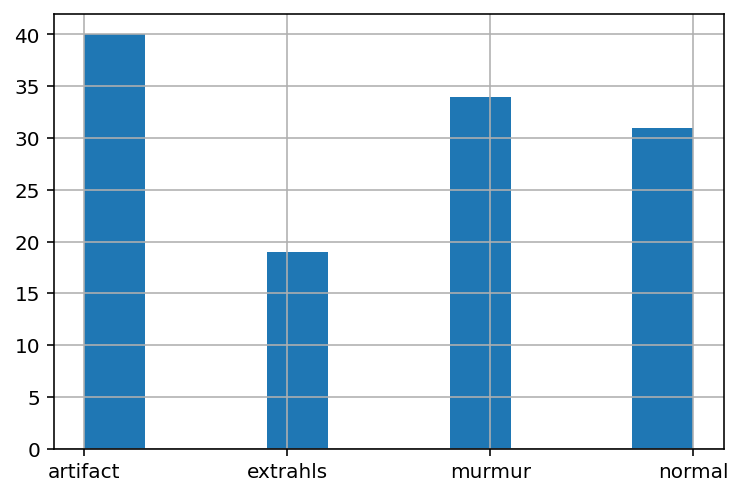

In [7]:
data_a.label.hist()

In [8]:
#read third dataset
data_b=pd.read_csv(INPUT_DIR+"/set_b.csv")
#read first five rows of the dataset
data_b.head()

,dataset,fname,label,sublabel
0,b,set_b/Btraining_extrastole_127_1306764300147_C...,extrastole,NaN
1,b,set_b/Btraining_extrastole_128_1306344005749_A...,extrastole,NaN
2,b,set_b/Btraining_extrastole_130_1306347376079_D...,extrastole,NaN
3,b,set_b/Btraining_extrastole_134_1306428161797_C...,extrastole,NaN
4,b,set_b/Btraining_extrastole_138_1306762146980_B...,extrastole,NaN


In [9]:
#merge both data-a and data-b
frames = [data_a, data_b]
train_ab=pd.concat(frames)
train_ab.describe()

,dataset,fname,label,sublabel
count,832,832,585,149
unique,2,832,5,2
top,b,set_a/artifact__201012172012.wav,normal,noisynormal
freq,656,1,351,120


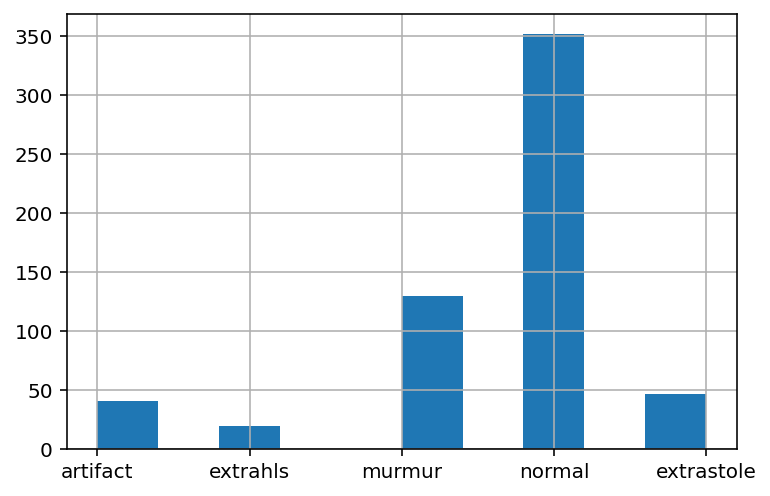

In [10]:
train_ab.label.hist() #we're dealing with an imbalanced dataset here

## Let's take a closer look/listen to our `normal` data:


### Playing audio files:

In [11]:
import IPython.display as ipd

normal_file = INPUT_DIR+"/set_a/normal__201106111136.wav"

#let's take a listen:
ipd.Audio(normal_file)

There are several different libraries that help us work with audio data: 
- `scipy.io`
- `librosa`

In [13]:
# Load use scipy
from scipy.io import wavfile
rate, data = wavfile.read(normal_file)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)

print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (218903,)
[-22835 -22726 -22595 ...   -474   -450   -439]


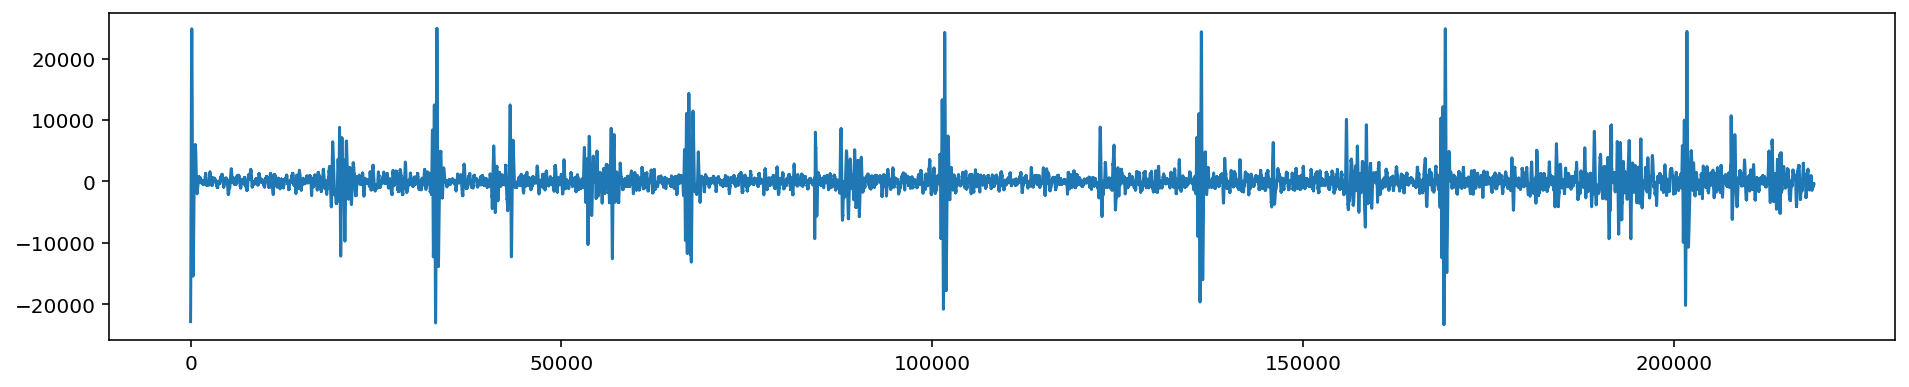

In [14]:
plt.figure(figsize=(16,3))
plt.plot(data,'-',);

In [15]:
# Load using Librosa
y, sr = librosa.load(normal_file, duration=5) #default sampling rate dur=librosa.get_duration(y)
dur = librosa.get_duration(y)
print ("duration:", dur)
print(y.shape, sr)

duration: 4.963809523809524
(109452,) 22050


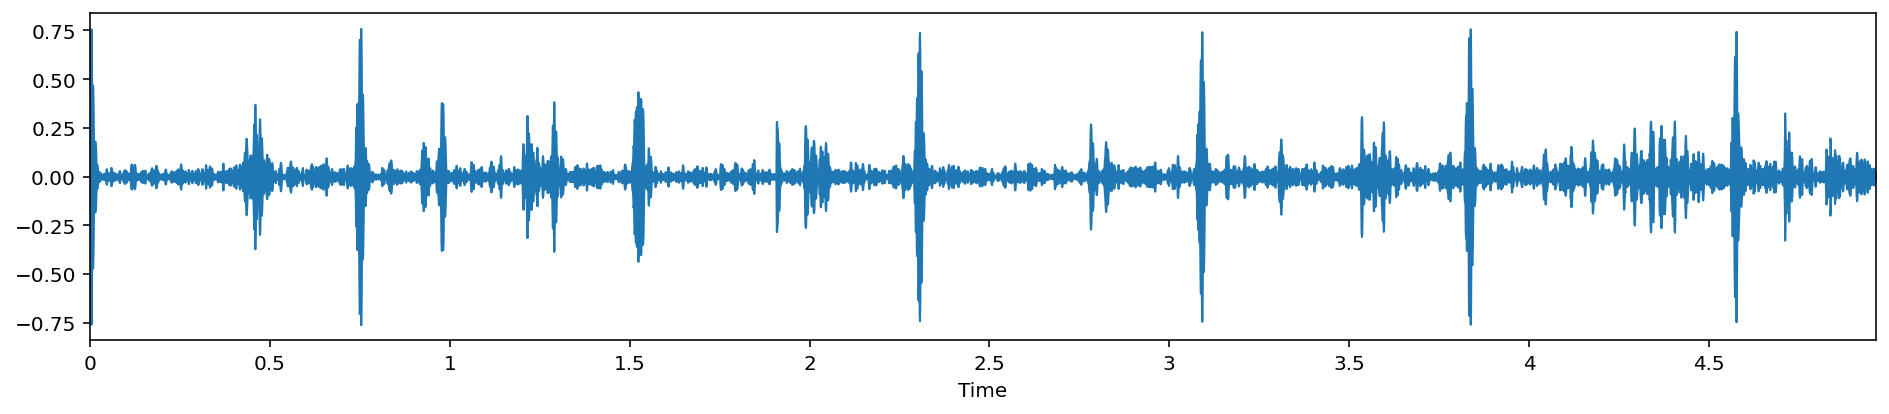

In [16]:
# plot using librosa:

plt.figure(figsize=(16,3))
librosa.display.waveplot(y,sr=sr)

## Let's listen to the `murmur` data now:

Murmurs often sound like 'whooshing, roaring, rumbling, or turbulent fluid'.

They can be a symptom of many heart disorders. 

In [17]:
# murmur case
murmur_file=INPUT_DIR+"/set_a/murmur__201108222231.wav"
y2, sr2 = librosa.load(murmur_file,duration=5)
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y2.shape,sr2)

duration: 4.963809523809524
(110250,) 22050


In [18]:
# hear it
import IPython.display as ipd
ipd.Audio(murmur_file) 

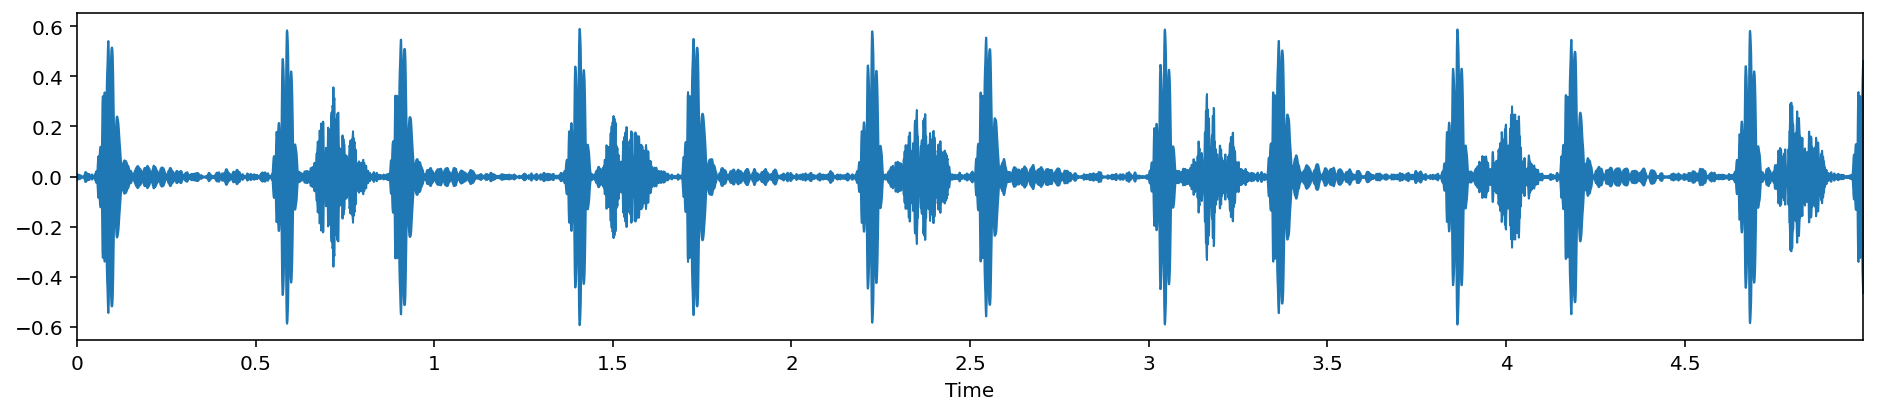

In [19]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y2, sr=sr2)

## Exercise #1:

Load in the file below--it is labeled as an `artifact`, which basically means it wasn't super clear when they recorded it. It might have background sounds or other noise. 
- play the file
- plot the file

Why might recognizing the `artifact` category be important?

In [20]:
artifact_file=INPUT_DIR+"/set_a/artifact__201012172012.wav"

# play the file

In [21]:
#plot the file


# Audio Pre-Processing: Feature Extraction

Audio is sampled at a pretty high rate (44100 Hz) which leads to 1D data, but very dense 1D data. 

It is helpful to calculate **Features** from our data rather than using the raw data to make predictions. 

One of the most common __sound features__ is `Mel Frequency Cepstral Coefficient (MFCCs)`. 
- it is a pretty complex calculation that we're not going to get into [(resource describing the calculation)](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)

In [22]:
# Here's a sample generate mfccs from a wave file
normal_file=INPUT_DIR+"/set_a/normal__201106111136.wav"
#y, sr = librosa.load(sample_file, offset=7, duration=7)
y, sr = librosa.load(normal_file)
mfccs = librosa.feature.mfcc(y=y, sr=sr)
print(mfccs)
print(mfccs.shape)

[[-2.4445940e+02 -2.9017612e+02 -4.0244815e+02 ... -3.6827570e+02
  -3.7070844e+02 -3.7255878e+02]
 [ 8.7494217e+01  9.7723938e+01  1.3325668e+02 ...  1.5185077e+02
   1.5726196e+02  1.5255161e+02]
 [ 1.0470561e+02  8.6485886e+01  2.3744190e+01 ...  2.8598265e+01
   2.9376595e+01  3.7390667e+01]
 ...
 [-1.3075645e+01 -7.9767680e+00 -1.1898985e+00 ...  2.2901213e-01
   6.2485218e-01  1.2895757e+00]
 [ 1.5359783e-01 -7.1130145e-01 -1.5883589e-01 ...  2.1378932e+00
  -2.1505746e-01  4.7633858e+00]
 [ 3.6015232e+00 -7.2055709e-01 -2.7711043e+00 ...  2.6977630e+00
  -1.3875163e+00  1.9455273e+00]]
(20, 214)


In [23]:
# Get more components
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
#print (mfccs)

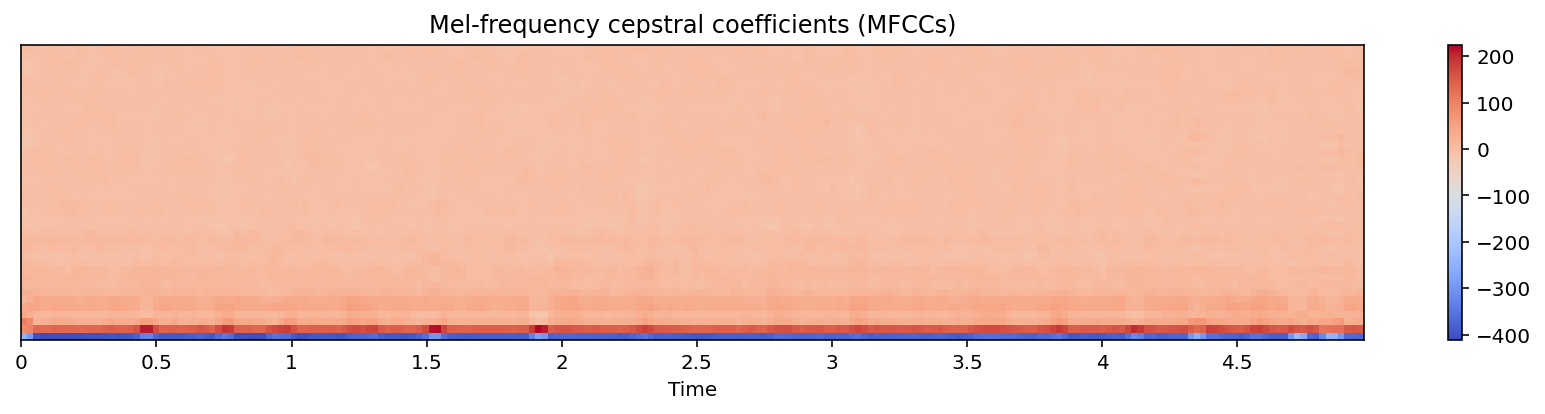

In [24]:
# Visualize the MFCC series
# Mel-frequency cepstral coefficients (MFCCs)
plt.figure(figsize=(12, 3))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (MFCCs)')
plt.tight_layout()

## Detect when sound starts: __Onset Detection__

In [25]:
# Get onset times from a signal
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
librosa.frames_to_time(onset_frames, sr=sr)

array([0.48761905, 0.7662585 , 0.95201814, 1.25387755, 1.53251701,
       1.92725624, 2.32199546, 2.80961451, 3.11147392, 3.57587302,
       3.80807256, 3.85451247, 4.13315193, 4.36535147, 4.59755102,
       4.73687075, 4.85297052])

In [26]:
# use a pre-computed onset envelope
o_env = librosa.onset.onset_strength(y, sr=sr)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

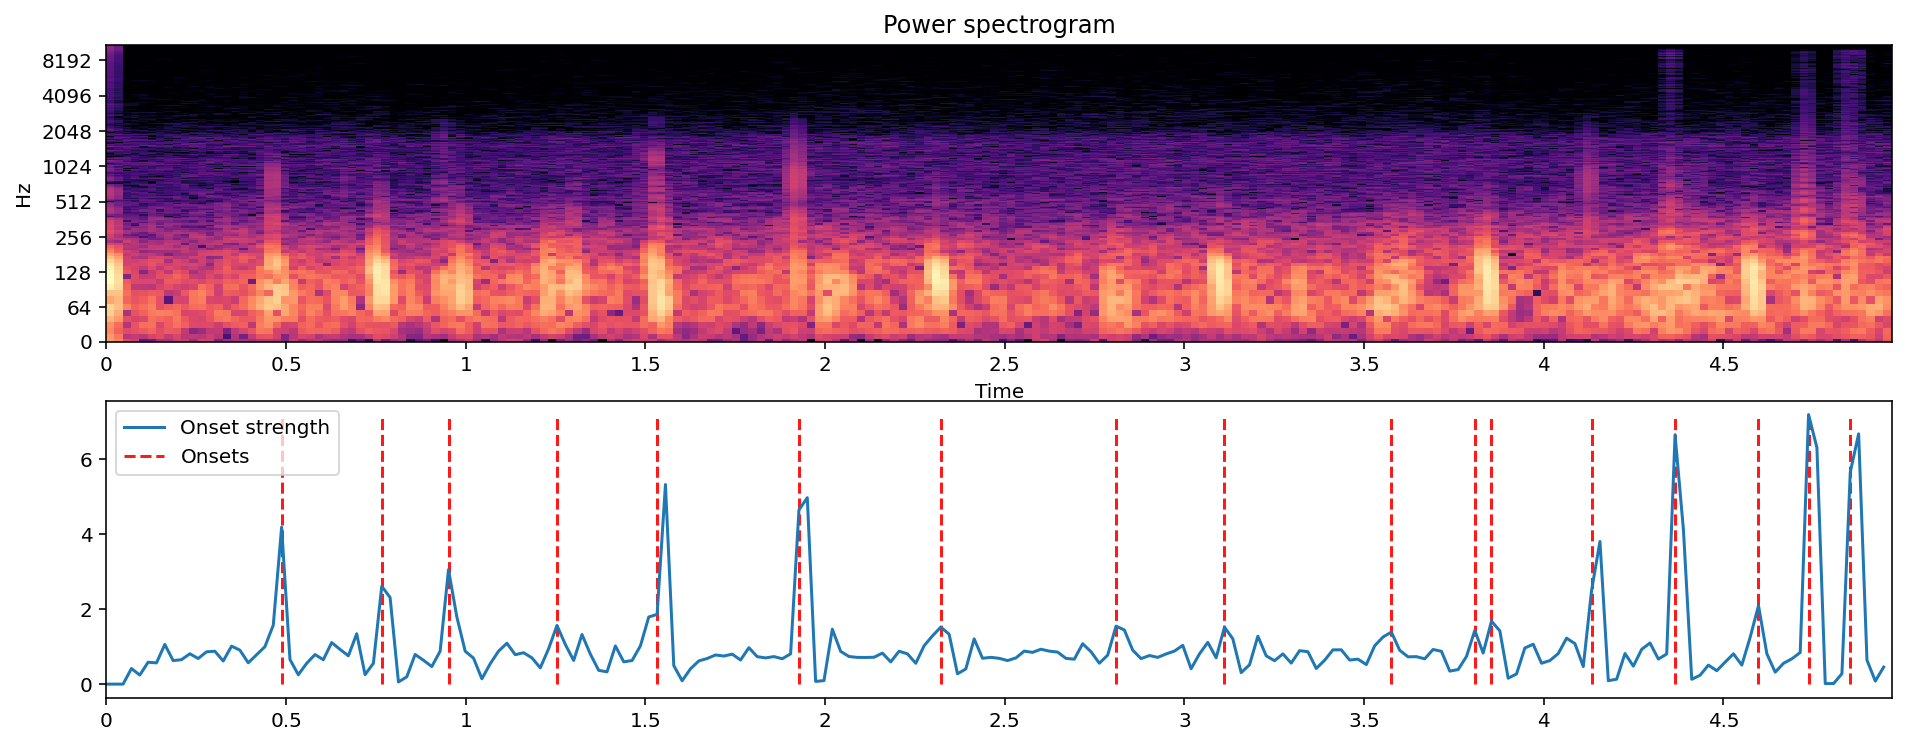

In [27]:
# visualize it
D = np.abs(librosa.stft(y))
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),x_axis='time', y_axis='log')
plt.title('Power spectrogram')
plt.subplot(2, 1, 2, sharex=ax1)

plt.plot(times, o_env, label='Onset strength')
plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,linestyle='--', label='Onsets')
plt.axis('tight')
plt.legend(frameon=True, framealpha=0.75)

In [28]:
# get audio data with a fix padding may also chop off some file
def load_file_data (folder,file_names, duration=12, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            #print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                #print ("fixing audio length :", file_name)
                y = librosa.util.fix_length(X, input_length)                
            #normalized raw audio 
            # y = audio_norm(y)            
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)             
        except Exception as e:
            print("Error encountered while parsing file: ", file)        
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

# get audio data without padding highest qualify audio
def load_file_data_without_change(folder,file_names, duration=3, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            #print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0) 
        except Exception as e:
            print("Error encountered while parsing file: ", file)
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data


In [29]:
# simple encoding of categories, limited to 3 types
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Map label text to integer
CLASSES = ['artifact','murmur','normal']
# {'artifact': 0, 'murmur': 1, 'normal': 3}
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


In [ ]:
# load dataset-a, keep them separate for testing purpose
import os, fnmatch

A_folder=INPUT_DIR+'/set_a/'
# set-a
A_artifact_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'artifact*.wav')
A_artifact_sounds = load_file_data(folder=A_folder,file_names=A_artifact_files, duration=MAX_SOUND_CLIP_DURATION)
A_artifact_labels = [0 for items in A_artifact_files]

A_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'normal*.wav')
A_normal_sounds = load_file_data(folder=A_folder,file_names=A_normal_files, duration=MAX_SOUND_CLIP_DURATION)
A_normal_labels = [2 for items in A_normal_sounds]

A_extrahls_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'extrahls*.wav')
A_extrahls_sounds = load_file_data(folder=A_folder,file_names=A_extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
A_extrahls_labels = [1 for items in A_extrahls_sounds]

A_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'murmur*.wav')
A_murmur_sounds = load_file_data(folder=A_folder,file_names=A_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
A_murmur_labels = [1 for items in A_murmur_files]

# test files
A_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'Aunlabelledtest*.wav')
A_unlabelledtest_sounds = load_file_data(folder=A_folder,file_names=A_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
A_unlabelledtest_labels = [-1 for items in A_unlabelledtest_sounds]

print ("loaded dataset-a")

In [ ]:
%%time
# load dataset-b, keep them separate for testing purpose 
B_folder=INPUT_DIR+'/set_b/'
# set-b
B_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'normal*.wav')  # include noisy files
B_normal_sounds = load_file_data(folder=B_folder,file_names=B_normal_files, duration=MAX_SOUND_CLIP_DURATION)
B_normal_labels = [2 for items in B_normal_sounds]

B_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'murmur*.wav')  # include noisy files
B_murmur_sounds = load_file_data(folder=B_folder,file_names=B_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
B_murmur_labels = [1 for items in B_murmur_files]

B_extrastole_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'extrastole*.wav')
B_extrastole_sounds = load_file_data(folder=B_folder,file_names=B_extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
B_extrastole_labels = [1 for items in B_extrastole_files]

#test files
B_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'Bunlabelledtest*.wav')
B_unlabelledtest_sounds = load_file_data(folder=B_folder,file_names=B_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
B_unlabelledtest_labels = [-1 for items in B_unlabelledtest_sounds]
print ("loaded dataset-b")

In [ ]:
#combine set-a and set-b 
x_data = np.concatenate((A_artifact_sounds, A_normal_sounds,A_extrahls_sounds,A_murmur_sounds, 
                         B_normal_sounds,B_murmur_sounds,B_extrastole_sounds))

y_data = np.concatenate((A_artifact_labels, A_normal_labels,A_extrahls_labels,A_murmur_labels,
                         B_normal_labels,B_murmur_labels,B_extrastole_labels))

test_x = np.concatenate((A_unlabelledtest_sounds,B_unlabelledtest_sounds))
test_y = np.concatenate((A_unlabelledtest_labels,B_unlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))

In [ ]:
# shuffle - whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.
# random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
# simple encoding of categories, limited to 3 types
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools
import keras

seed = 1000
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.9, random_state=seed, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=seed, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(keras.utils.to_categorical(test_y, len(CLASSES)))

# Let's build our model:

In [ ]:
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, return_sequences=True,input_shape = (40,1)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(len(CLASSES), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['acc','mse', 'mae', 'mape'])
model.summary()

In [ ]:
%%time
# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"
#train_model_file=file_path+"/checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=100
MAX_BATCH=32

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

print ("training started..... please wait.")
# training
history=model.fit(x_train, y_train, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(x_val, y_val),
                  callbacks=callback) 

print ("training finised!")

training started..... please wait.

Epoch 1: loss improved from inf to 0.42750, saving model to ./best_model_trained.hdf5

Epoch 2: loss improved from 0.42750 to 0.42739, saving model to ./best_model_trained.hdf5

Epoch 3: loss improved from 0.42739 to 0.41737, saving model to ./best_model_trained.hdf5

Epoch 4: loss improved from 0.41737 to 0.41529, saving model to ./best_model_trained.hdf5

Epoch 5: loss improved from 0.41529 to 0.41120, saving model to ./best_model_trained.hdf5

Epoch 6: loss improved from 0.41120 to 0.40546, saving model to ./best_model_trained.hdf5

Epoch 7: loss did not improve from 0.40546

Epoch 8: loss did not improve from 0.40546

Epoch 9: loss improved from 0.40546 to 0.40097, saving model to ./best_model_trained.hdf5

Epoch 10: loss did not improve from 0.40097

Epoch 11: loss did not improve from 0.40097

Epoch 12: loss improved from 0.40097 to 0.39721, saving model to ./best_model_trained.hdf5

Epoch 13: loss did not improve from 0.39721

Epoch 14: loss i

<Figure size 1584x720 with 0 Axes>

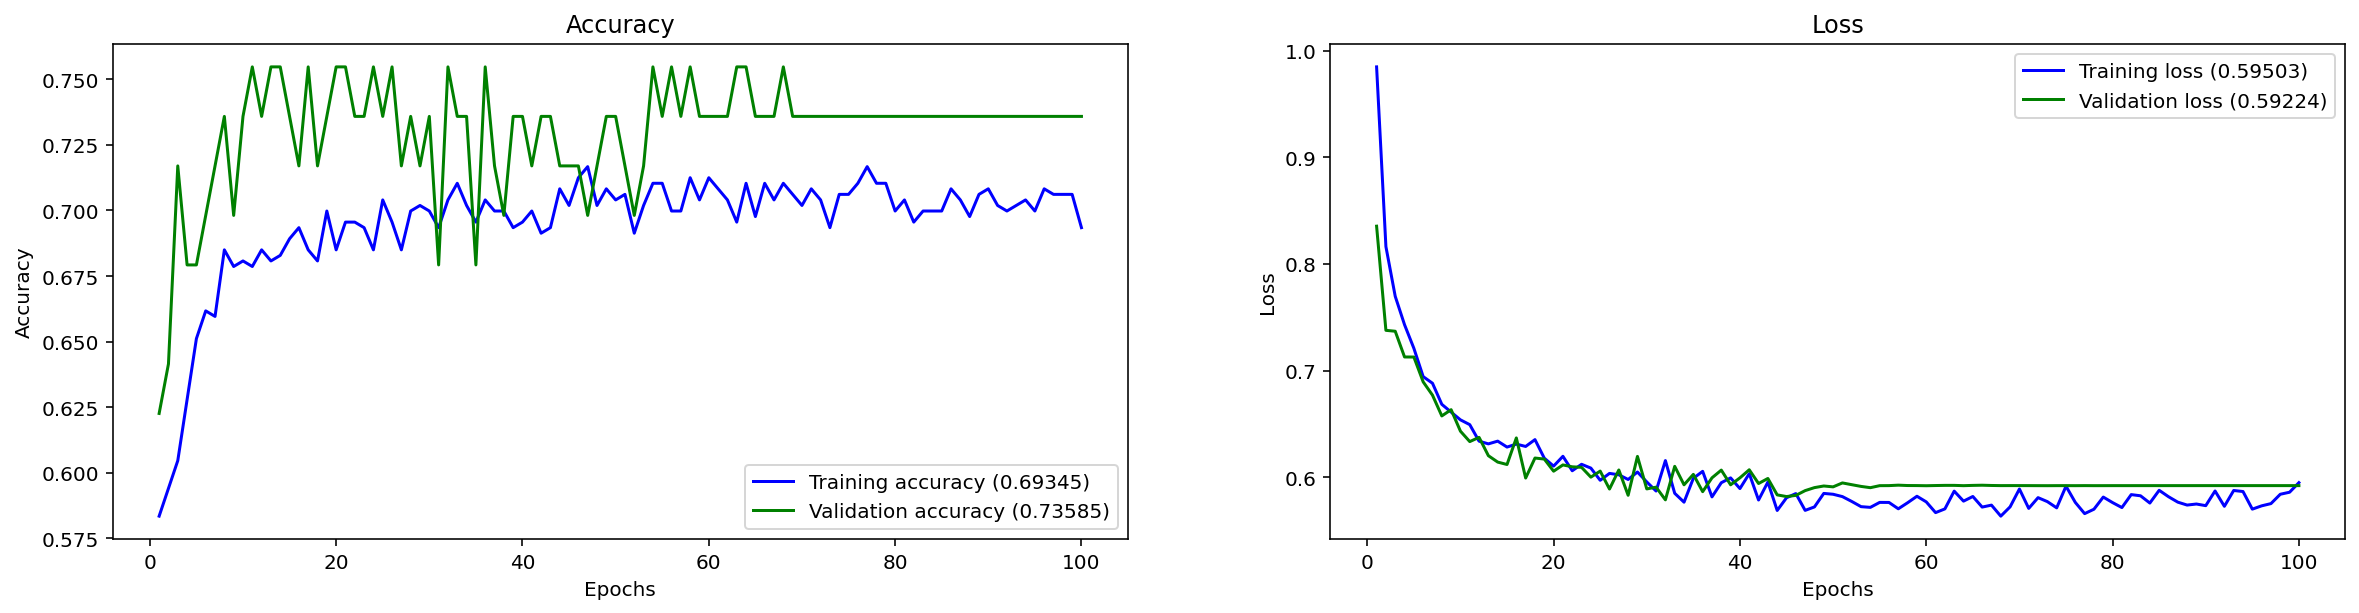

CPU times: user 418 ms, sys: 8.81 ms, total: 427 ms
Wall time: 459 ms


In [ ]:
%%time
#Plot Keras History
#Plot loss and accuracy for the training and validation set.
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    plt.figure(figsize=(22,10))
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Accuracy
    plt.figure(221, figsize=(20,10))
    ## Accuracy
    # plt.figure(2,figsize=(14,5))
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# plot history
plot_history(history)

In [1]:
### Loading a Check-Pointed Neural Network Model
# How to load and use weights from a checkpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# create model
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.35, return_sequences=True,input_shape = (40,1)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
model.add(Dense(len(CLASSES), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
model.summary()
# load weights
model.load_weights(best_model_file)
# Compile model (required to make predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")

Build LSTM RNN model ...


NameError: ignored

In [ ]:
%%time
# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"
#train_model_file=file_path+"/checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=100
MAX_BATCH=32

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

print ("re-starting training from previous checkpoint..... please wait.")
# training
history=model.fit(x_train, y_train, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(x_val, y_val),
                  callbacks=callback) 

print ("training finised!")